# Merging the FEMA and MLS DataFrames

## Summary

In this notebook, I will combine data from the FEMA claims and averaged data from the home listings according to their corresponding locations.

## Import

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import copy

pd.set_option('display.max_columns', None) # Displays all columns

from scipy.stats import kurtosis, skew

import warnings
warnings.filterwarnings('ignore')

### Functions

In [2]:
def view(dataframe, n: int=3):
    """Displays the preview of the first and last rows of the dataframe
    Args:
        dataframe: The dataframe being called
        n: Number of rows to select for preview. Defaults to 3.
    Returns:
        The first n and the last n rows of the dataframe
    """

    with pd.option_context('display.max_rows',n*2):
        display(dataframe)

In [3]:
def rename(dataframe, column, original, rename):
    """Replaces all instances of a specific string in one column with a new string
    Args:
        dataframe: The dataframe being called
        column: The column being called
        oringal: Original string to be replaced
        rename: New string to replace original string
    """

    dataframe.loc[dataframe[column].str.contains(original), column] = str(rename)
    return

In [4]:
def stats(dataframe, column):
    """Generates single column stats and boxplot
    Args:
        dataframe: The dataframe being called
        column: The column being called
    Returns:
        Descriptive statistics and boxplot of the column
    """
    
    print(f'Data type: {dataframe[column].dtype}')
    print(f'Count: {dataframe[column].shape[0]}')
    print(f'Number of Unique Values: {dataframe[column].nunique()}')
    print(f'Number of nulls: {dataframe[column].isna().sum()} - {round(100*dataframe[column].isna().sum()/len(dataframe),2)}%')
    print()
    print(f'Mean: {dataframe[column].mean()}')
    print(f'Minimum: {dataframe[column].min()}')
    print(f'Lower Quartile: {dataframe[column].quantile(.25)}')
    print(f'Median: {dataframe[column].quantile(.5)}')
    print(f'Upper Quartile: {dataframe[column].quantile(.75)}')
    print(f'Maximum: {dataframe[column].max()}')

    plt.figure(figsize=(10,1))
    plt.title(f'Boxplot Distrubution of {column}', fontsize=14, fontweight='bold')
    ax = sns.boxplot(x=dataframe[column])
    plt.xlabel(column, fontsize=13, fontweight='bold')
    plt.show()

In [5]:
def preview_cols(dataframe):
    """Generates quick preview of each column in the dataframe
    Args:
        dataframe: The dataframe being called
    Returns:
        Datatype
        Number of unique values
        Number of nulls
        Descriptive statistics and boxplot for numeric columns
        The first n and the last n values of the column
        Visualization of most frequent values
        
    """
    
    for i in dataframe.columns:
        print(i.upper())
        print()
        if (dataframe[i].dtype=='int' or dataframe[i].dtype=='float'): 
            print(stats(dataframe,i))
        else: 
            print(f'Data type: {dataframe[i].dtype}')
            print(f'Number of unique values: {dataframe[i].nunique()}')
            print(f'Number of nulls: {dataframe[i].isna().sum()} - {round(100*dataframe[i].isna().sum()/len(dataframe),2)}%')
            print (dataframe[i].describe())
        print()
        print(view(dataframe[~dataframe[i].isna()][i].astype('str').value_counts().sort_index()))
        print()
        dataframe[i].value_counts().head(20).plot(kind='barh', figsize=(8,6))
        plt.title(f'Most common values in the {i} column', fontsize=14, fontweight='bold')
        plt.ylabel('Value', fontsize=13, fontweight='bold')
        plt.xlabel('Frequency of Occurence', fontsize=13, fontweight='bold')
        plt.show()
        print()
        print('*'*50)
        print()

## FEMA Data: Load and Preview

In [6]:
df = pd.read_csv('fema_harvey_cleaned.csv', index_col=0)

In [7]:
view(df,3)

,damagedcity,damagedzipcode,householdcomposition,specialneeds,residencetype,homeownersinsurance,floodinsurance,destroyed,waterlevel,flooddamage,foundationdamage,roofdamage,tsaeligible,tsacheckedin,rentalassistanceeligible,repairassistanceeligible,replacementassistanceeligible,sbaeligible,primaryresidence,personalpropertyeligible,ppfvl,censusblockid
8,MISSOURI CITY,77489,2,False,House/Duplex,True,False,False,0.0,False,False,False,False,False,False,False,False,False,True,False,0.0,4.815767e+14
12,HOUSTON,77043,1,False,House/Duplex,True,True,False,0.0,False,False,False,True,False,False,False,False,False,True,False,0.0,4.820152e+14
13,HOUSTON,77017,5,False,House/Duplex,True,False,False,0.0,False,False,False,True,False,False,False,False,False,True,False,0.0,4.820132e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895516,HOUSTON,77051,1,False,House/Duplex,False,False,False,0.0,False,False,False,False,False,False,False,False,False,True,False,0.0,4.820133e+14
895520,HOUSTON,77084,3,False,House/Duplex,True,False,False,0.0,False,False,True,False,False,False,False,False,False,True,False,0.0,4.820154e+14
895522,EAST BERNARD,77435,1,False,House/Duplex,True,True,False,72.0,True,False,False,True,False,True,False,False,False,True,False,0.0,4.848174e+14


In [8]:
df = df[['damagedcity','damagedzipcode','householdcomposition','homeownersinsurance','floodinsurance','flooddamage']]

### Info

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181035 entries, 8 to 895522
Data columns (total 6 columns):
damagedcity             181035 non-null object
damagedzipcode          181035 non-null int64
householdcomposition    181035 non-null int64
homeownersinsurance     181035 non-null bool
floodinsurance          181035 non-null bool
flooddamage             181035 non-null bool
dtypes: bool(3), int64(2), object(1)
memory usage: 6.0+ MB


### Describe

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
damagedzipcode,181035.0,77274.200845,221.709879,77002.0,77053.0,77338.0,77502.0,78954.0
householdcomposition,181035.0,2.862485,1.701902,1.0,1.0,2.0,4.0,22.0


### Preview Columns

DAMAGEDCITY

Data type: object
Number of unique values: 189
Number of nulls: 0 - 0.0%
count      181035
unique        189
top       HOUSTON
freq        87275
Name: damagedcity, dtype: object



ALGOA            2
ALVIN         1615
AMES            11
              ... 
WINNIE         468
WOODBRANCH       1
WOODLOCH         1
Name: damagedcity, Length: 189, dtype: int64

None



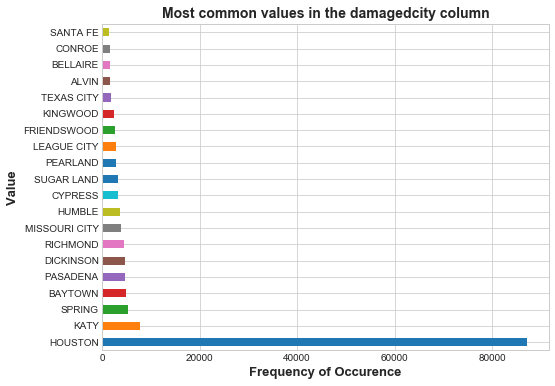


**************************************************

DAMAGEDZIPCODE

Data type: int64
Count: 181035
Number of Unique Values: 228
Number of nulls: 0 - 0.0%

Mean: 77274.20084514044
Minimum: 77002
Lower Quartile: 77053.0
Median: 77338.0
Upper Quartile: 77502.0
Maximum: 78954


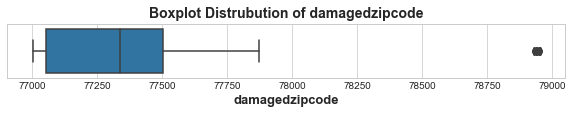

None



77002     75
77003    164
77004    685
        ... 
78944      4
78950      9
78954      5
Name: damagedzipcode, Length: 228, dtype: int64

None



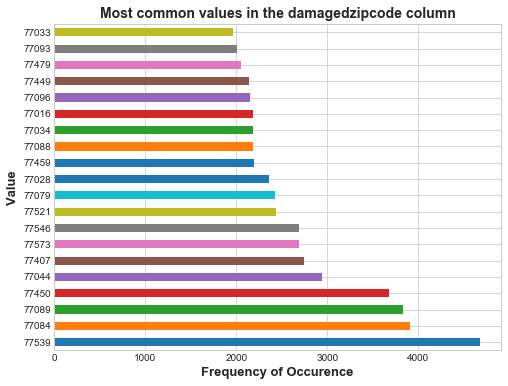


**************************************************

HOUSEHOLDCOMPOSITION

Data type: int64
Count: 181035
Number of Unique Values: 20
Number of nulls: 0 - 0.0%

Mean: 2.8624851548043195
Minimum: 1
Lower Quartile: 1.0
Median: 2.0
Upper Quartile: 4.0
Maximum: 22


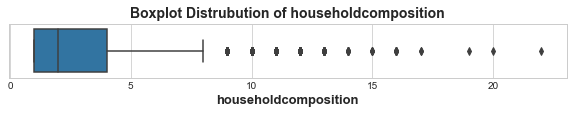

None



1     45372
10      231
11      106
      ...  
7      3189
8      1300
9       572
Name: householdcomposition, Length: 20, dtype: int64

None



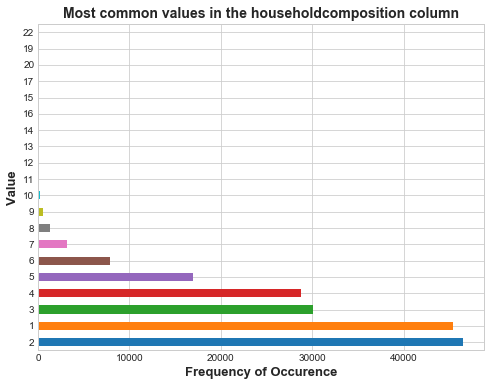


**************************************************

HOMEOWNERSINSURANCE

Data type: bool
Number of unique values: 2
Number of nulls: 0 - 0.0%
count     181035
unique         2
top         True
freq      121868
Name: homeownersinsurance, dtype: object



False     59167
True     121868
Name: homeownersinsurance, dtype: int64

None



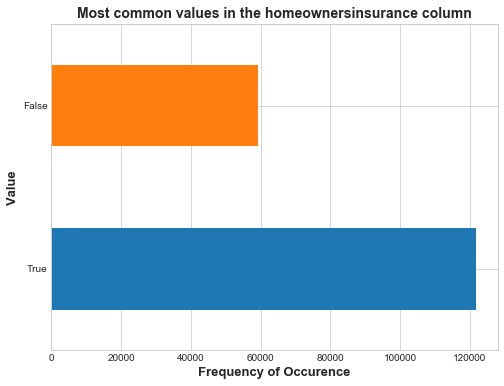


**************************************************

FLOODINSURANCE

Data type: bool
Number of unique values: 2
Number of nulls: 0 - 0.0%
count     181035
unique         2
top        False
freq      131977
Name: floodinsurance, dtype: object



False    131977
True      49058
Name: floodinsurance, dtype: int64

None



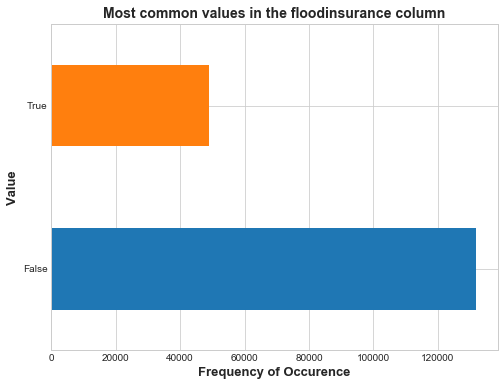


**************************************************

FLOODDAMAGE

Data type: bool
Number of unique values: 2
Number of nulls: 0 - 0.0%
count     181035
unique         2
top         True
freq       91929
Name: flooddamage, dtype: object



False    89106
True     91929
Name: flooddamage, dtype: int64

None



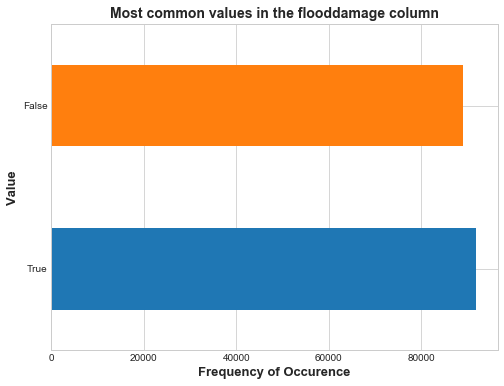


**************************************************



In [11]:
preview_cols(df)

## MLS Data: Load and Preview

In [12]:
mls = pd.read_csv('har_explored_cleaned.csv', index_col=0)

In [13]:
view(mls,3)

,mls_number,property_type,status,city,zip_code,county,list_price,area,school_district,school_high,sq_ft_total,lot_size,year_built,bedrooms,baths_full,baths_half,stories,new_construction,pool_private,dom,cdom,list_date,fireplace,garage,home_age,age_when_listed
3,47405549,Single-Family,Sold,Winnie,77665,Chambers,39900,53,18 - East Chambers,EAST CHAMBERS HIGH SCHOOL,672.0,2688.0,1952,2.0,1.0,0.0,1.0,0,0,0.0,123,2017-08-23,0,0,67,65
4,86143414,Townhouse/Condo,Sold,Galveston,77554,Galveston,25000,33,22 - Galveston,BALL HIGH SCHOOL,801.0,2242.8,1984,1.0,1.0,0.0,2.0,0,0,49.0,49,2017-07-07,1,1,35,33
6,99874455,Townhouse/Condo,Sold,Montgomery,77356,Montgomery,36000,39,37 - Montgomery,MONTGOMERY HIGH SCHOOL,489.0,1956.0,1979,1.0,1.0,0.0,1.0,0,0,86.0,86,2017-06-02,0,0,40,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371320,43582225,Single-Family,Withdrawn,Houston,77007,Harris,998000,9,27 - Houston,HEIGHTS HIGH SCHOOL,3724.0,3010.0,2018,4.0,3.0,1.0,3.0,0,0,61.0,61,2018-12-24,1,1,1,0
371323,53833919,Single-Family,Withdrawn,Houston,77025,Harris,999000,17,27 - Houston,LAMAR HIGH SCHOOL (HOUSTON),4299.0,9167.0,2005,4.0,3.0,1.0,2.0,0,0,111.0,319,2018-03-28,1,1,14,13
371325,85354305,Single-Family,Withdrawn,Houston,77092,Harris,999900,9,27 - Houston,WALTRIP HIGH SCHOOL,1814.0,23760.0,1950,2.0,2.0,0.0,1.0,0,0,140.0,140,2018-11-14,0,1,69,68


### Info

In [14]:
mls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301005 entries, 3 to 371325
Data columns (total 26 columns):
mls_number          301005 non-null int64
property_type       301005 non-null object
status              301005 non-null object
city                301005 non-null object
zip_code            301005 non-null int64
county              301005 non-null object
list_price          301005 non-null int64
area                301005 non-null int64
school_district     301005 non-null object
school_high         301005 non-null object
sq_ft_total         301005 non-null float64
lot_size            301005 non-null float64
year_built          301005 non-null int64
bedrooms            301005 non-null float64
baths_full          301005 non-null float64
baths_half          301005 non-null float64
stories             301005 non-null float64
new_construction    301005 non-null int64
pool_private        301005 non-null int64
dom                 301005 non-null float64
cdom                301005 no

### Describe

In [15]:
mls.describe().T

,count,mean,std,min,25%,50%,75%,max
mls_number,301005.0,5.050719e+07,2.819025e+07,104240.0,26156414.0,50411488.0,74872732.0,338218412.0
zip_code,301005.0,7.731530e+04,1.973751e+02,77002.0,77080.0,77379.0,77478.0,78950.0
list_price,301005.0,2.940667e+05,1.558607e+05,20000.0,189000.0,256990.0,359900.0,1000000.0
area,301005.0,2.105661e+01,1.293942e+01,1.0,9.0,20.0,33.0,86.0
sq_ft_total,301005.0,2.434047e+03,8.947533e+02,450.0,1780.0,2315.0,2960.0,25229.0
lot_size,301005.0,9.975661e+03,1.091935e+04,0.0,6023.0,7627.0,9840.0,99927.0
year_built,301005.0,1.996972e+03,1.880724e+01,1950.0,1982.0,2003.0,2013.0,2019.0
bedrooms,301005.0,3.530320e+00,7.668206e-01,1.0,3.0,4.0,4.0,5.0
baths_full,301005.0,2.342317e+00,6.633182e-01,1.0,2.0,2.0,3.0,4.0
baths_half,301005.0,5.544426e-01,5.319054e-01,0.0,0.0,1.0,1.0,2.0


### Column Values

MLS_NUMBER

Data type: int64
Count: 301005
Number of Unique Values: 301005
Number of nulls: 0 - 0.0%

Mean: 50507188.56636601
Minimum: 104240
Lower Quartile: 26156414.0
Median: 50411488.0
Upper Quartile: 74872732.0
Maximum: 338218412


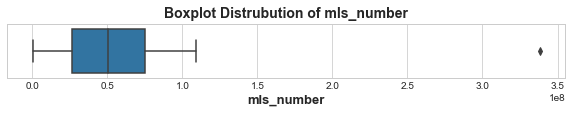

None



10000122    1
10000191    1
10000324    1
           ..
99999204    1
99999419    1
9999959     1
Name: mls_number, Length: 301005, dtype: int64

None



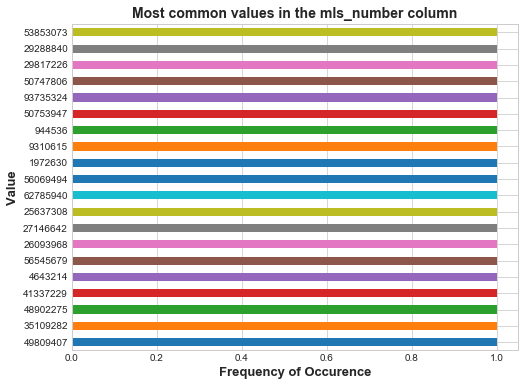


**************************************************

PROPERTY_TYPE

Data type: object
Number of unique values: 2
Number of nulls: 0 - 0.0%
count            301005
unique                2
top       Single-Family
freq             279450
Name: property_type, dtype: object



Single-Family      279450
Townhouse/Condo     21555
Name: property_type, dtype: int64

None



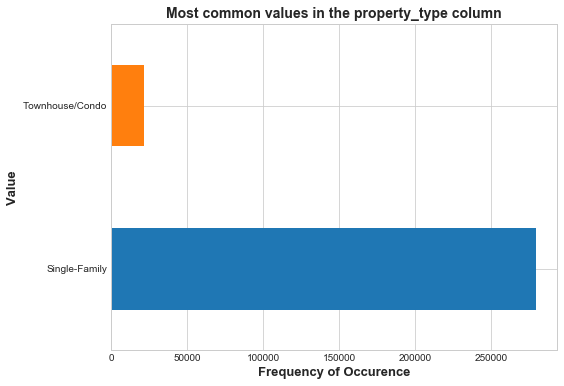


**************************************************

STATUS

Data type: object
Number of unique values: 8
Number of nulls: 0 - 0.0%
count     301005
unique         8
top         Sold
freq      176024
Name: status, dtype: object



Active             21516
Expired            27568
Option Pending      1957
                   ...  
Sold              176024
Terminated         62607
Withdrawn           2503
Name: status, Length: 8, dtype: int64

None



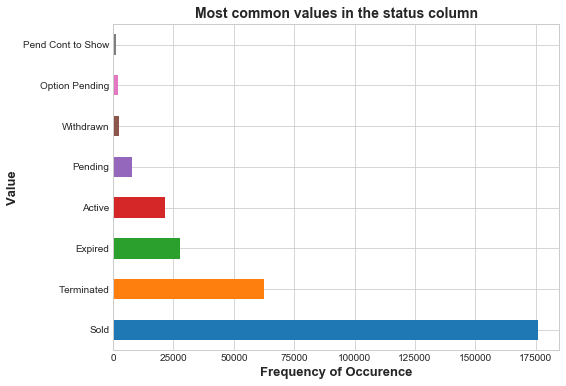


**************************************************

CITY

Data type: object
Number of unique values: 93
Number of nulls: 0 - 0.0%
count      301005
unique         93
top       Houston
freq       102617
Name: city, dtype: object



Alief               2
Alvin            1325
Anahuac            92
                 ... 
West Columbia     179
Willis           2076
Winnie             49
Name: city, Length: 93, dtype: int64

None



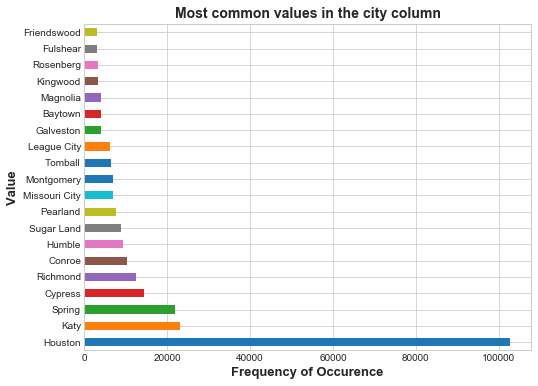


**************************************************

ZIP_CODE

Data type: int64
Count: 301005
Number of Unique Values: 218
Number of nulls: 0 - 0.0%

Mean: 77315.3015929968
Minimum: 77002
Lower Quartile: 77080.0
Median: 77379.0
Upper Quartile: 77478.0
Maximum: 78950


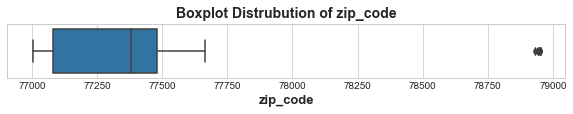

None



77002      50
77003     924
77004    1324
         ... 
78933       1
78944       2
78950       8
Name: zip_code, Length: 218, dtype: int64

None



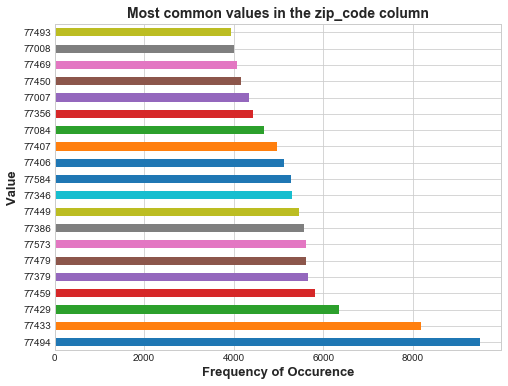


**************************************************

COUNTY

Data type: object
Number of unique values: 9
Number of nulls: 0 - 0.0%
count     301005
unique         9
top       Harris
freq      177617
Name: county, dtype: object



Austin          469
Brazoria      14262
Chambers       1817
              ...  
Liberty        1678
Montgomery    34653
Waller         1910
Name: county, Length: 9, dtype: int64

None



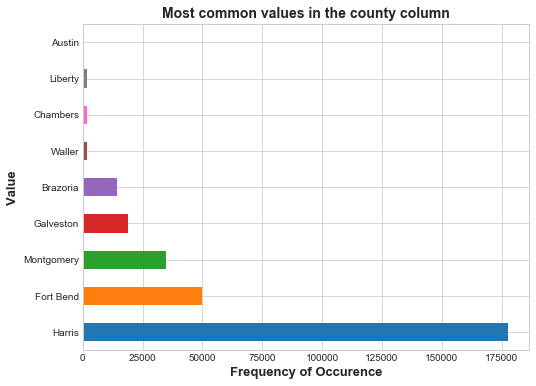


**************************************************

LIST_PRICE

Data type: int64
Count: 301005
Number of Unique Values: 24952
Number of nulls: 0 - 0.0%

Mean: 294066.6731150645
Minimum: 20000
Lower Quartile: 189000.0
Median: 256990.0
Upper Quartile: 359900.0
Maximum: 1000000


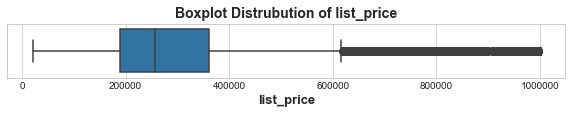

None



100000     345
1000000     54
100400       1
          ... 
999990       3
999995       5
999999      40
Name: list_price, Length: 24952, dtype: int64

None



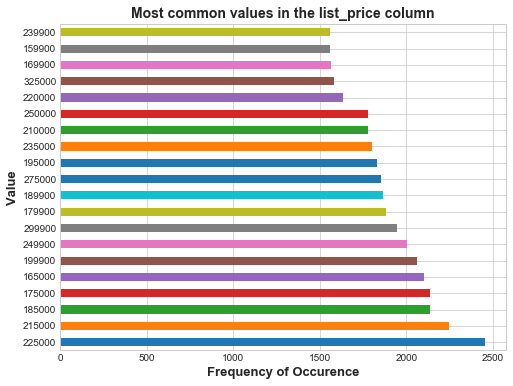


**************************************************

AREA

Data type: int64
Count: 301005
Number of Unique Values: 60
Number of nulls: 0 - 0.0%

Mean: 21.056607033105763
Minimum: 1
Lower Quartile: 9.0
Median: 20.0
Upper Quartile: 33.0
Maximum: 86


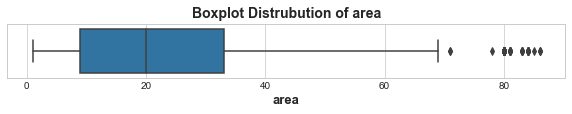

None



1     12508
10     7540
11     3120
      ...  
85        1
86        3
9     11722
Name: area, Length: 60, dtype: int64

None



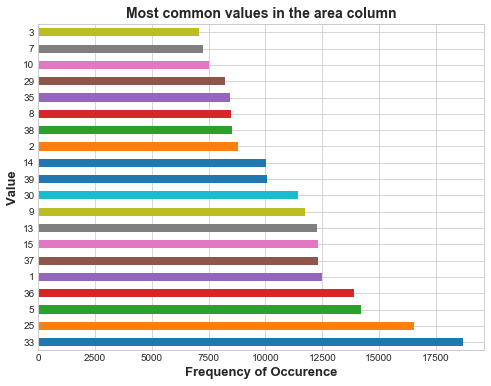


**************************************************

SCHOOL_DISTRICT

Data type: object
Number of unique values: 70
Number of nulls: 0 - 0.0%
count           301005
unique              70
top       27 - Houston
freq             47192
Name: school_district, dtype: object



1 - Aldine                 5447
10 - Columbia-Brazoria      302
100 - Cleveland             357
                          ...  
8 - Channelview             706
9 - Clear Creek           11981
99 - Other                   67
Name: school_district, Length: 70, dtype: int64

None



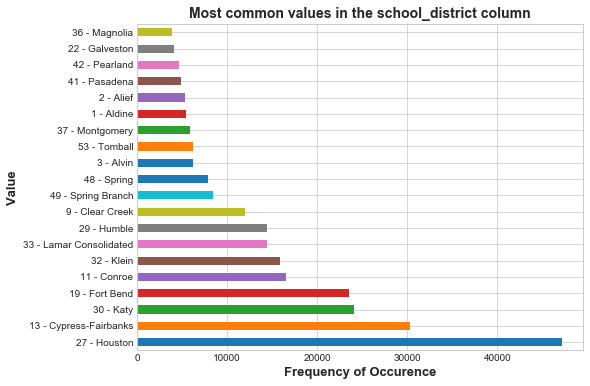


**************************************************

SCHOOL_HIGH

Data type: object
Number of unique values: 203
Number of nulls: 0 - 0.0%
count                          301005
unique                            203
top       LAMAR HIGH SCHOOL (HOUSTON)
freq                             6560
Name: school_high, dtype: object



AISD DRAW               5328
ALDINE HIGH SCHOOL       435
ALVIN HIGH SCHOOL       1369
                        ... 
WISDOM HIGH SCHOOL      3719
WORTHING HIGH SCHOOL    2153
YATES HIGH SCHOOL       1404
Name: school_high, Length: 203, dtype: int64

None



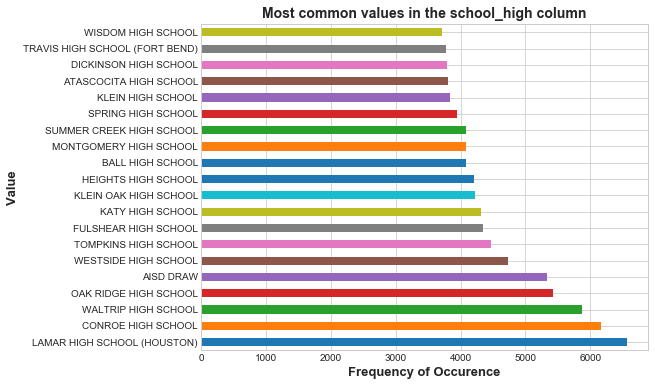


**************************************************

SQ_FT_TOTAL

Data type: float64
Count: 301005
Number of Unique Values: 5286
Number of nulls: 0 - 0.0%

Mean: 2434.0470922409927
Minimum: 450.0
Lower Quartile: 1780.0
Median: 2315.0
Upper Quartile: 2960.0
Maximum: 25229.0


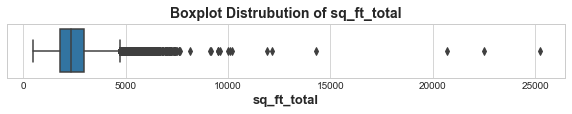

None



1000.0     102
10000.0      1
1001.0      30
          ... 
997.0       19
998.0       41
999.0       12
Name: sq_ft_total, Length: 5286, dtype: int64

None



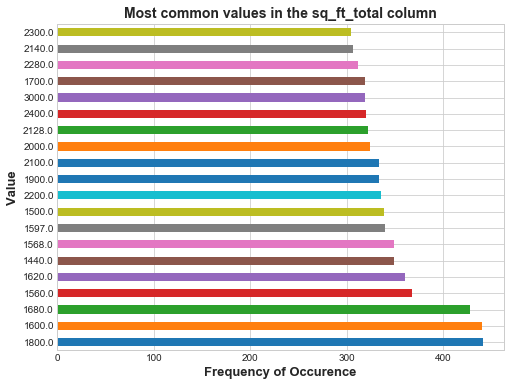


**************************************************

LOT_SIZE

Data type: float64
Count: 301005
Number of Unique Values: 25669
Number of nulls: 0 - 0.0%

Mean: 9975.660857460838
Minimum: 0.0
Lower Quartile: 6023.0
Median: 7627.0
Upper Quartile: 9840.0
Maximum: 99927.0


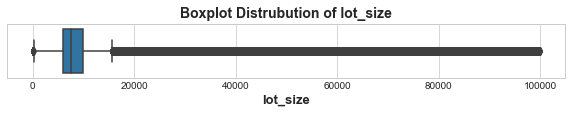

None



0.0       745
1.0         6
1000.0      6
         ... 
9998.8      1
9999.0      9
9999.4     18
Name: lot_size, Length: 25669, dtype: int64

None



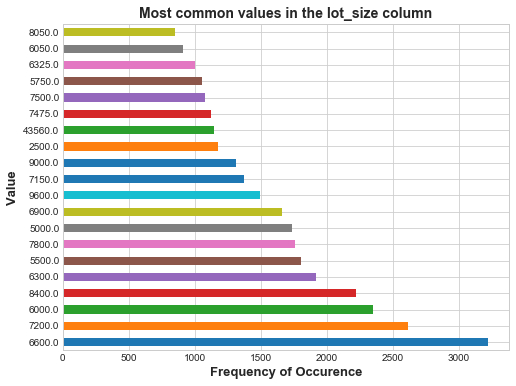


**************************************************

YEAR_BUILT

Data type: int64
Count: 301005
Number of Unique Values: 70
Number of nulls: 0 - 0.0%

Mean: 1996.971970565273
Minimum: 1950
Lower Quartile: 1982.0
Median: 2003.0
Upper Quartile: 2013.0
Maximum: 2019


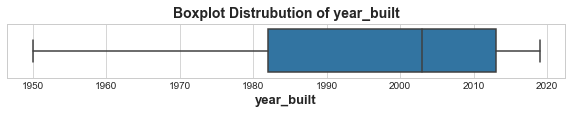

None



1950     2804
1951      529
1952     1056
        ...  
2017    18380
2018    18965
2019     9903
Name: year_built, Length: 70, dtype: int64

None



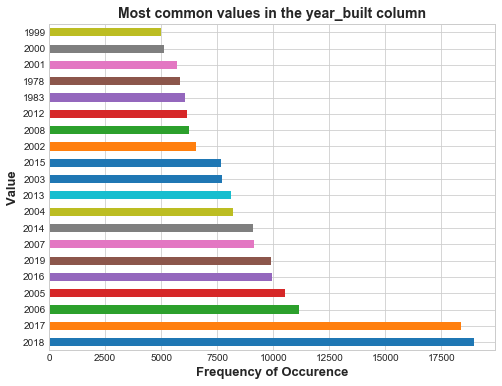


**************************************************

BEDROOMS

Data type: float64
Count: 301005
Number of Unique Values: 5
Number of nulls: 0 - 0.0%

Mean: 3.5303200943505924
Minimum: 1.0
Lower Quartile: 3.0
Median: 4.0
Upper Quartile: 4.0
Maximum: 5.0


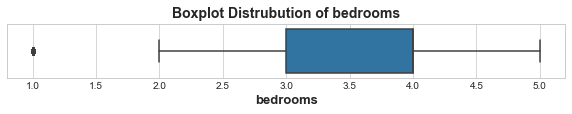

None



1.0      3033
2.0     15614
3.0    127346
4.0    128715
5.0     26297
Name: bedrooms, dtype: int64

None



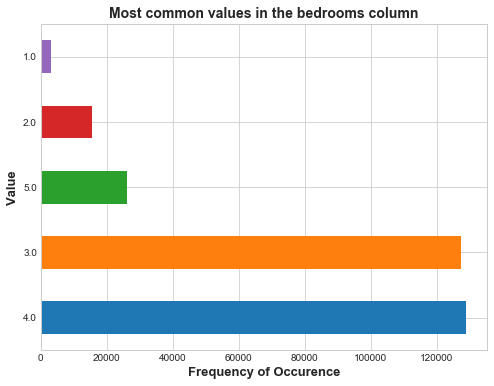


**************************************************

BATHS_FULL

Data type: float64
Count: 301005
Number of Unique Values: 4
Number of nulls: 0 - 0.0%

Mean: 2.342316572814405
Minimum: 1.0
Lower Quartile: 2.0
Median: 2.0
Upper Quartile: 3.0
Maximum: 4.0


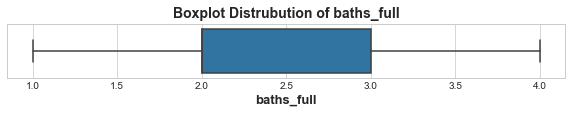

None



1.0     15811
2.0    182869
3.0     85800
4.0     16525
Name: baths_full, dtype: int64

None



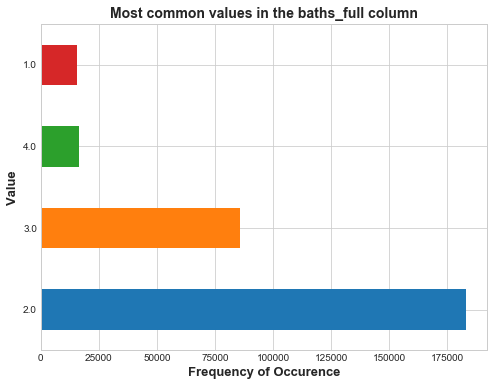


**************************************************

BATHS_HALF

Data type: float64
Count: 301005
Number of Unique Values: 3
Number of nulls: 0 - 0.0%

Mean: 0.5544426172322718
Minimum: 0.0
Lower Quartile: 0.0
Median: 1.0
Upper Quartile: 1.0
Maximum: 2.0


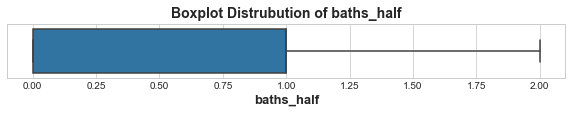

None



0.0    139516
1.0    156088
2.0      5401
Name: baths_half, dtype: int64

None



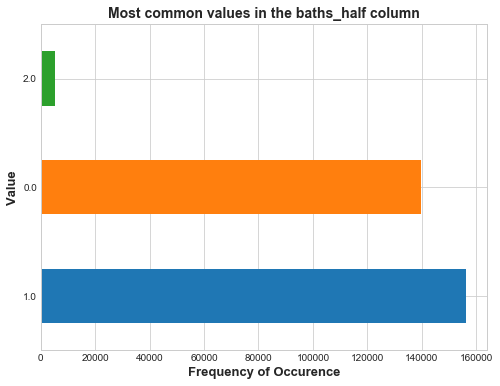


**************************************************

STORIES

Data type: float64
Count: 301005
Number of Unique Values: 6
Number of nulls: 0 - 0.0%

Mean: 1.571605122838491
Minimum: 1.0
Lower Quartile: 1.0
Median: 2.0
Upper Quartile: 2.0
Maximum: 3.5


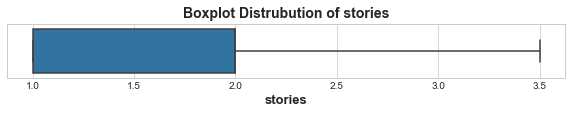

None



1.0    139302
1.5      7297
2.0    140325
2.5       188
3.0     13864
3.5        29
Name: stories, dtype: int64

None



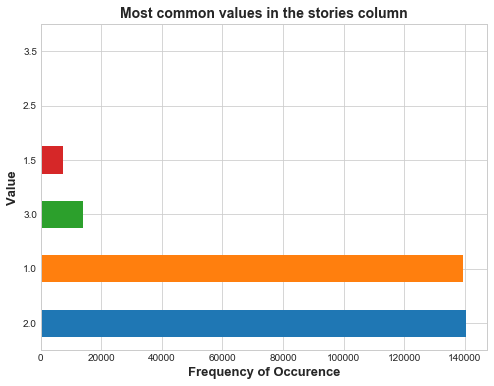


**************************************************

NEW_CONSTRUCTION

Data type: int64
Count: 301005
Number of Unique Values: 2
Number of nulls: 0 - 0.0%

Mean: 0.17702031527715487
Minimum: 0
Lower Quartile: 0.0
Median: 0.0
Upper Quartile: 0.0
Maximum: 1


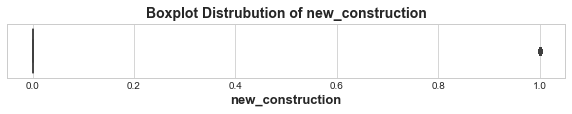

None



0    247721
1     53284
Name: new_construction, dtype: int64

None



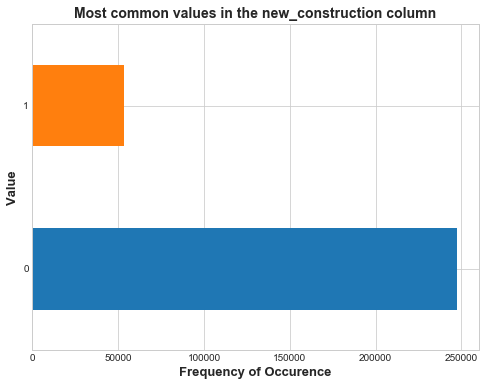


**************************************************

POOL_PRIVATE

Data type: int64
Count: 301005
Number of Unique Values: 2
Number of nulls: 0 - 0.0%

Mean: 0.10612116077806016
Minimum: 0
Lower Quartile: 0.0
Median: 0.0
Upper Quartile: 0.0
Maximum: 1


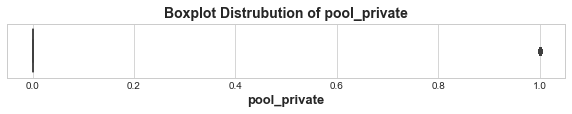

None



0    269062
1     31943
Name: pool_private, dtype: int64

None



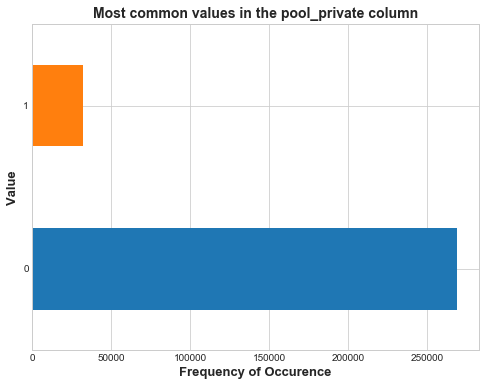


**************************************************

DOM

Data type: float64
Count: 301005
Number of Unique Values: 781
Number of nulls: 0 - 0.0%

Mean: 65.94849254995763
Minimum: -54.0
Lower Quartile: 12.0
Median: 41.0
Upper Quartile: 93.0
Maximum: 1541.0


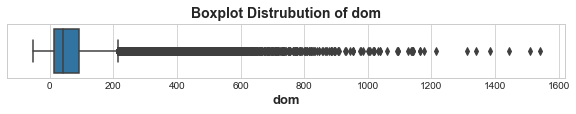

None



-1.0        4
-28.0       1
-54.0       1
         ... 
98.0     1055
986.0       1
99.0      939
Name: dom, Length: 781, dtype: int64

None



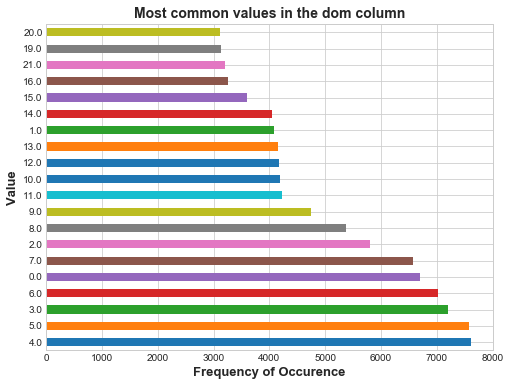


**************************************************

CDOM

Data type: int64
Count: 301005
Number of Unique Values: 1222
Number of nulls: 0 - 0.0%

Mean: 98.98407003205926
Minimum: 0
Lower Quartile: 15.0
Median: 57.0
Upper Quartile: 136.0
Maximum: 1600


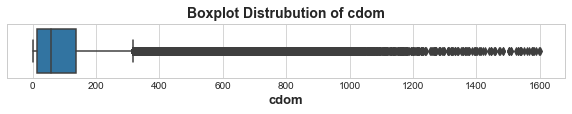

None



0      5747
1      3569
10     3587
       ... 
997       1
998       1
999       1
Name: cdom, Length: 1222, dtype: int64

None



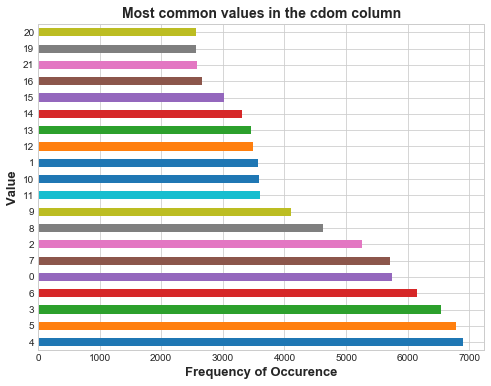


**************************************************

LIST_DATE

Data type: object
Number of unique values: 1548
Number of nulls: 0 - 0.0%
count         301005
unique          1548
top       2018-06-01
freq             640
Name: list_date, dtype: object



2002-10-22      1
2008-08-11      1
2009-01-06      1
             ... 
2019-06-18    388
2019-06-19    426
2019-06-20      6
Name: list_date, Length: 1548, dtype: int64

None



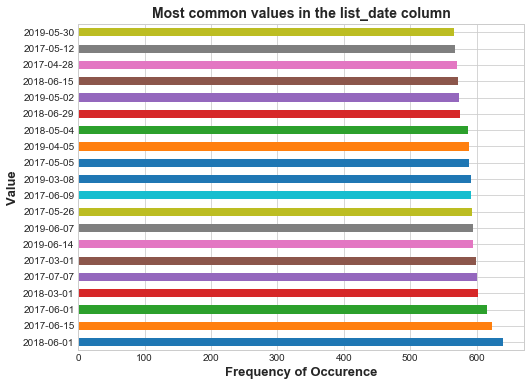


**************************************************

FIREPLACE

Data type: int64
Count: 301005
Number of Unique Values: 2
Number of nulls: 0 - 0.0%

Mean: 0.6215677480440525
Minimum: 0
Lower Quartile: 0.0
Median: 1.0
Upper Quartile: 1.0
Maximum: 1


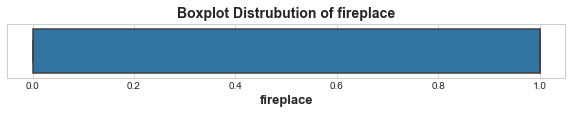

None



0    113910
1    187095
Name: fireplace, dtype: int64

None



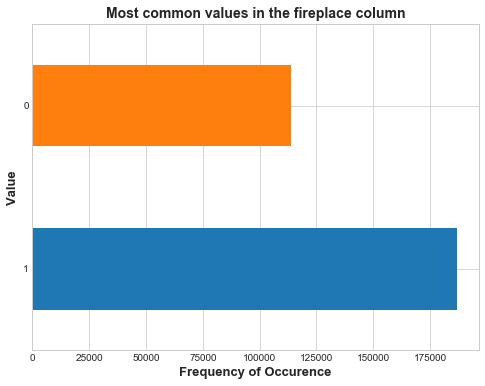


**************************************************

GARAGE

Data type: int64
Count: 301005
Number of Unique Values: 2
Number of nulls: 0 - 0.0%

Mean: 0.92231358283085
Minimum: 0
Lower Quartile: 1.0
Median: 1.0
Upper Quartile: 1.0
Maximum: 1


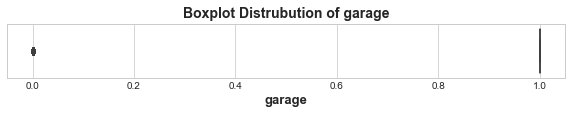

None



0     23384
1    277621
Name: garage, dtype: int64

None



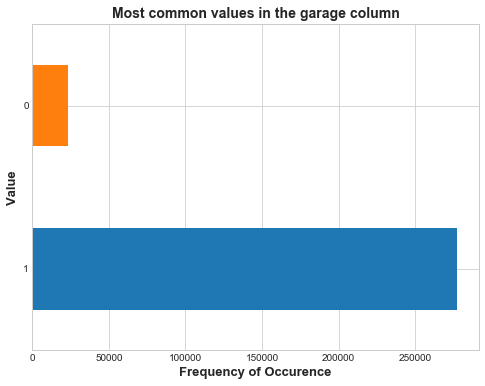


**************************************************

HOME_AGE

Data type: int64
Count: 301005
Number of Unique Values: 70
Number of nulls: 0 - 0.0%

Mean: 22.028029434727
Minimum: 0
Lower Quartile: 6.0
Median: 16.0
Upper Quartile: 37.0
Maximum: 69


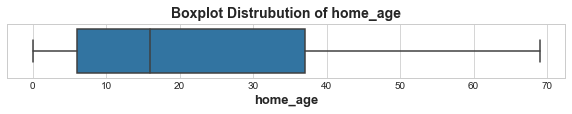

None



0      9903
1     18965
10     4560
      ...  
7      6149
8      4685
9      4716
Name: home_age, Length: 70, dtype: int64

None



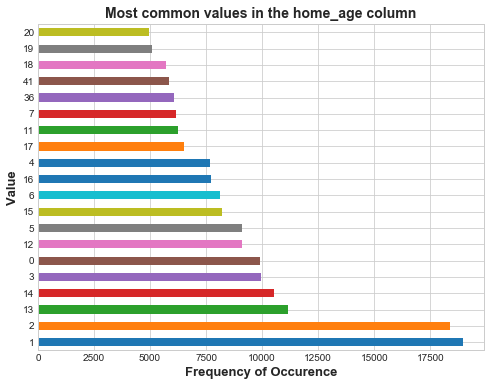


**************************************************

AGE_WHEN_LISTED

Data type: int64
Count: 301005
Number of Unique Values: 70
Number of nulls: 0 - 0.0%

Mean: 20.702589657979104
Minimum: 0
Lower Quartile: 4.0
Median: 15.0
Upper Quartile: 36.0
Maximum: 69


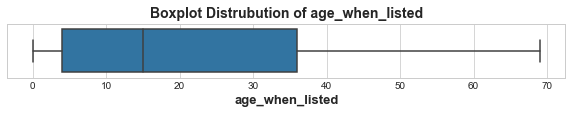

None



0     46218
1      7675
10     7496
      ...  
7      4908
8      4892
9      5506
Name: age_when_listed, Length: 70, dtype: int64

None



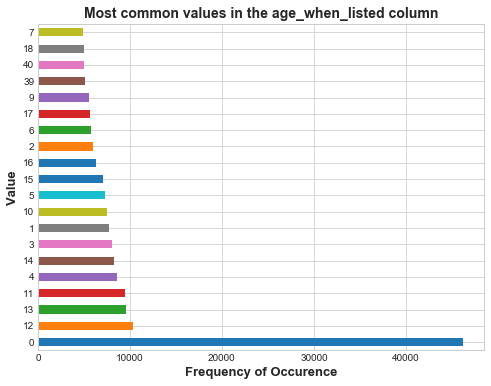


**************************************************



In [16]:
preview_cols(mls)

## Narrowing Zip Codes to those in FEMA data

In [17]:
fema_zips = list(df.damagedzipcode.unique())

In [18]:
mls.zip_code.unique()

array([77665, 77554, 77356, 77327, 77378, 77535, 77316, 77568, 77354,
       77303, 77590, 77423, 77517, 77328, 77484, 77357, 77445, 77302,
       77418, 77301, 77550, 77551, 77511, 77318, 77306, 77591, 77563,
       77385, 77469, 77486, 77546, 77372, 77053, 77489, 77515, 77584,
       77099, 77498, 77471, 77575, 77459, 77518, 77461, 77304, 77365,
       77541, 77386, 77510, 77539, 77474, 77534, 77083, 77480, 77523,
       77450, 77573, 77339, 77566, 77380, 77355, 77581, 77545, 77478,
       77406, 77384, 77583, 77521, 77362, 77477, 77447, 77407, 77578,
       77085, 77531, 77479, 77494, 77565, 77084, 77382, 77493, 77381,
       77441, 77433, 77514, 77021, 77035, 77078, 77029, 77071, 77036,
       77562, 77092, 77039, 77054, 77034, 77504, 77074, 77571, 77015,
       77072, 77026, 77032, 77033, 77091, 77042, 77017, 77090, 77076,
       77020, 77048, 77336, 77060, 77088, 77044, 77045, 77502, 77049,
       77505, 77063, 77057, 77016, 77547, 77532, 77396, 77037, 77080,
       77069, 77598,

In [19]:
mls.zip_code.nunique()

218

In [20]:
mls_zips = list(mls.zip_code.unique())

In [21]:
mls = mls[mls.zip_code.isin(fema_zips)]

In [22]:
mls.zip_code.nunique()

217

### Previewing

In [23]:
mls.columns

Index(['mls_number', 'property_type', 'status', 'city', 'zip_code', 'county',
       'list_price', 'area', 'school_district', 'school_high', 'sq_ft_total',
       'lot_size', 'year_built', 'bedrooms', 'baths_full', 'baths_half',
       'stories', 'new_construction', 'pool_private', 'dom', 'cdom',
       'list_date', 'fireplace', 'garage', 'home_age', 'age_when_listed'],
      dtype='object')

In [24]:
mls = mls[['zip_code','list_price','sq_ft_total','bedrooms','baths_full','baths_half','stories','home_age']]

In [25]:
view(mls,2)

,zip_code,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
3,77665,39900,672.0,2.0,1.0,0.0,1.0,67
4,77554,25000,801.0,1.0,1.0,0.0,2.0,35
...,...,...,...,...,...,...,...,...
371323,77025,999000,4299.0,4.0,3.0,1.0,2.0,14
371325,77092,999900,1814.0,2.0,2.0,0.0,1.0,69


## Averages

In [26]:
avg_mls = mls.copy(deep=True)

In [27]:
view(avg_mls,3)

,zip_code,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
3,77665,39900,672.0,2.0,1.0,0.0,1.0,67
4,77554,25000,801.0,1.0,1.0,0.0,2.0,35
6,77356,36000,489.0,1.0,1.0,0.0,1.0,40
...,...,...,...,...,...,...,...,...
371320,77007,998000,3724.0,4.0,3.0,1.0,3.0,1
371323,77025,999000,4299.0,4.0,3.0,1.0,2.0,14
371325,77092,999900,1814.0,2.0,2.0,0.0,1.0,69


In [28]:
mls_zips = list(avg_mls.zip_code.unique())

In [29]:
num_cols = avg_mls.describe().columns[1:]

In [30]:
for z in mls_zips:
    
    means = avg_mls[avg_mls.zip_code==int(z)][num_cols].mean()
    
    for n in num_cols:
        avg_mls.loc[avg_mls.zip_code==int(z), n] = means[n]

In [31]:
num_cols

Index(['list_price', 'sq_ft_total', 'bedrooms', 'baths_full', 'baths_half',
       'stories', 'home_age'],
      dtype='object')

In [32]:
view(avg_mls,5)

,zip_code,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
3,77665,183440.000000,1825.979592,3.244898,2.000000,0.346939,1.040816,41.632653
4,77554,374007.530009,1619.232687,2.934903,2.139428,0.265466,1.474608,23.779317
6,77356,326309.167118,2475.018042,3.228913,2.421065,0.527515,1.514659,19.460983
7,77327,178940.738144,1734.517526,3.045361,1.907216,0.148454,1.108247,26.938144
8,77378,206408.589661,1849.137318,3.224556,2.092084,0.403877,1.311793,14.295638
...,...,...,...,...,...,...,...,...
371316,77055,517808.071132,2407.182448,3.272517,2.450346,0.660508,1.944804,26.139954
371318,77018,471256.343146,2150.958699,3.246485,2.178383,0.561951,1.640598,32.796134
371320,77007,465287.284164,2329.932595,2.944367,2.617959,0.876500,2.676016,11.415743
371323,77025,431850.866667,2186.190909,3.038788,2.227273,0.488485,1.687273,41.666061


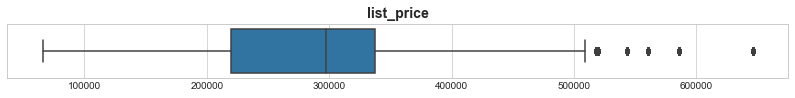

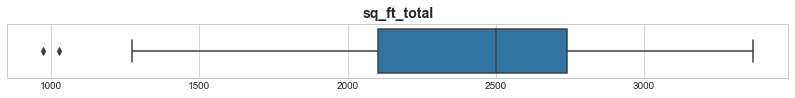

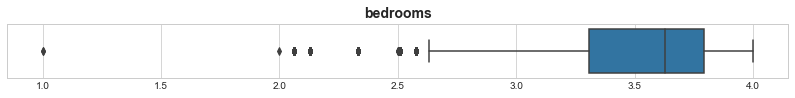

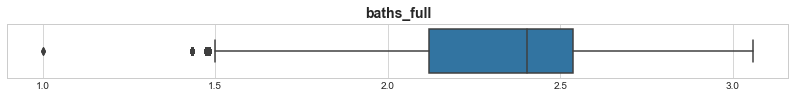

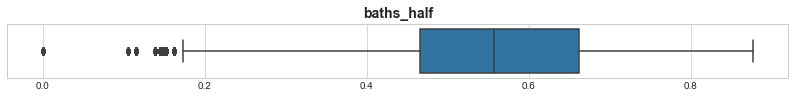

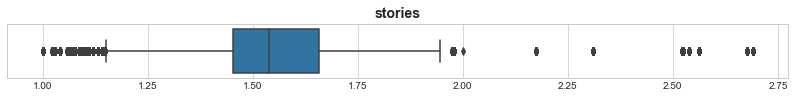

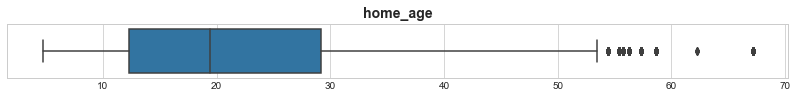

In [33]:
for n in num_cols:
    plt.figure(figsize=(14,1))
    sns.boxplot(avg_mls[n])
    plt.title(n, fontsize=14, fontweight='bold')
    plt.xlabel("", fontsize=13, fontweight='bold')
    plt.show()

In [34]:
avg_mls[avg_mls.bedrooms == avg_mls.bedrooms.min()]

,zip_code,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
263747,77010,439900.0,972.0,1.0,1.0,0.0,1.0,37.0
323471,77046,264000.0,1026.0,1.0,1.0,0.0,1.0,39.0


In [35]:
avg_mls[avg_mls.baths_full == avg_mls.baths_full.min()]

,zip_code,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
263747,77010,439900.0,972.0,1.0,1.0,0.0,1.0,37.0
323471,77046,264000.0,1026.0,1.0,1.0,0.0,1.0,39.0


In [36]:
avg_mls[avg_mls.baths_half == avg_mls.baths_half.min()]

,zip_code,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
7348,77538,65975.0,1273.000,2.500,1.50,0.0,1.00,62.25
9737,78950,321112.5,2167.875,3.375,2.25,0.0,1.25,31.75
21074,78950,321112.5,2167.875,3.375,2.25,0.0,1.25,31.75
45553,77538,65975.0,1273.000,2.500,1.50,0.0,1.00,62.25
54409,78950,321112.5,2167.875,3.375,2.25,0.0,1.25,31.75
70132,78944,149389.0,2074.000,4.000,2.50,0.0,1.50,30.00
85950,77538,65975.0,1273.000,2.500,1.50,0.0,1.00,62.25
88785,77538,65975.0,1273.000,2.500,1.50,0.0,1.00,62.25
89799,78950,321112.5,2167.875,3.375,2.25,0.0,1.25,31.75
141853,78933,200000.0,1626.000,2.000,2.00,0.0,2.00,15.00


In [37]:
view(avg_mls.zip_code.value_counts(),10)

77494    9486
77433    8177
77429    6337
77459    5810
77379    5648
77479    5601
77573    5600
77386    5568
77449    5447
77346    5294
         ... 
77444      19
77597      18
77564      17
77560      11
78950       8
77538       4
78944       2
77046       1
78933       1
77010       1
Name: zip_code, Length: 217, dtype: int64

In [38]:
mls.describe().T

,count,mean,std,min,25%,50%,75%,max
zip_code,301003.0,77315.300857,197.375529,77002.0,77080.0,77379.0,77478.0,78950.0
list_price,301003.0,294066.546164,155861.198671,20000.0,189000.0,256990.0,359900.0,1000000.0
sq_ft_total,301003.0,2434.044956,894.755470,450.0,1780.0,2315.0,2960.0,25229.0
bedrooms,301003.0,3.530314,0.766818,1.0,3.0,4.0,4.0,5.0
baths_full,301003.0,2.342312,0.663318,1.0,2.0,2.0,3.0,4.0
baths_half,301003.0,0.554440,0.531906,0.0,0.0,1.0,1.0,2.0
stories,301003.0,1.571602,0.575988,1.0,1.0,2.0,2.0,3.5
home_age,301003.0,22.028176,18.807221,0.0,6.0,16.0,37.0,69.0


In [39]:
avg_mls.describe().T

,count,mean,std,min,25%,50%,75%,max
zip_code,301003.0,77315.300857,197.375529,77002.000000,77080.000000,77379.000000,77478.000000,78950.000000
list_price,301003.0,294066.546164,91566.208053,65975.000000,219980.646817,297100.098389,337790.389673,646146.891278
sq_ft_total,301003.0,2434.044956,440.194573,972.000000,2102.631241,2500.691143,2740.056493,3367.054759
bedrooms,301003.0,3.530314,0.341135,1.000000,3.308571,3.626994,3.794224,4.000000
baths_full,301003.0,2.342312,0.278315,1.000000,2.119008,2.404852,2.537374,3.058067
baths_half,301003.0,0.554440,0.156249,0.000000,0.465698,0.557054,0.662346,0.876500
stories,301003.0,1.571602,0.266201,1.000000,1.453296,1.539542,1.656652,2.690476
home_age,301003.0,22.028176,11.894057,4.705882,12.318465,19.460983,29.159349,67.173077


ZIP_CODE

Data type: int64
Count: 301003
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 77315.30085746654
Minimum: 77002
Lower Quartile: 77080.0
Median: 77379.0
Upper Quartile: 77478.0
Maximum: 78950


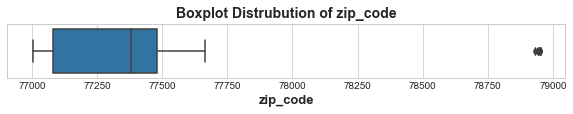

None



77002      50
77003     924
77004    1324
         ... 
78933       1
78944       2
78950       8
Name: zip_code, Length: 217, dtype: int64

None



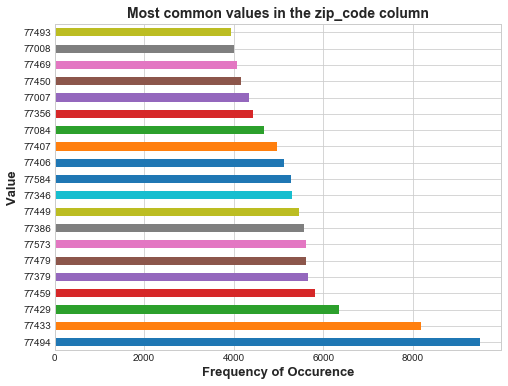


**************************************************

LIST_PRICE

Data type: float64
Count: 301003
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 294066.5461639917
Minimum: 65975.0
Lower Quartile: 219980.64681724846
Median: 297100.0983886256
Upper Quartile: 337790.3896729776
Maximum: 646146.8912783752


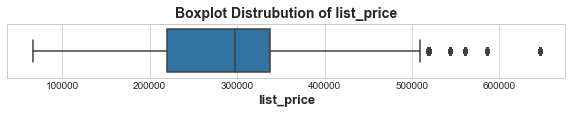

None



104757.02884615384    104
109972.92833333333    600
110215.26482213438    253
                     ... 
65975.0                 4
85426.31578947368      19
94247.05882352941      17
Name: list_price, Length: 217, dtype: int64

None



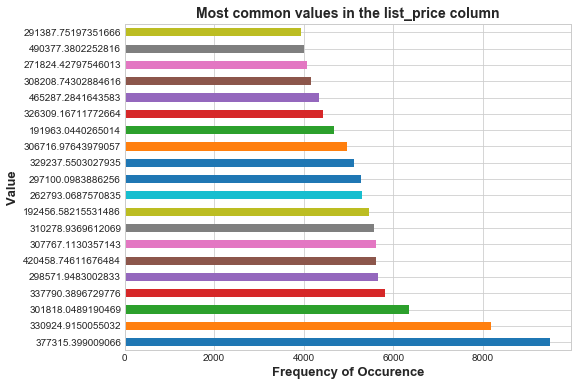


**************************************************

SQ_FT_TOTAL

Data type: float64
Count: 301003
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 2434.0449563625616
Minimum: 972.0
Lower Quartile: 2102.6312410841656
Median: 2500.6911430734294
Upper Quartile: 2740.0564928909953
Maximum: 3367.0547592796765


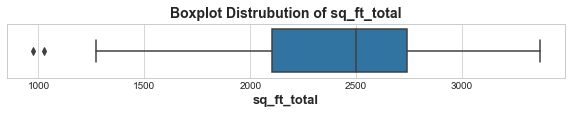

None



1026.0                   1
1273.0                   4
1286.4736842105262      19
                      ... 
3248.2162576687115     652
3367.0547592796765    2721
972.0                    1
Name: sq_ft_total, Length: 217, dtype: int64

None



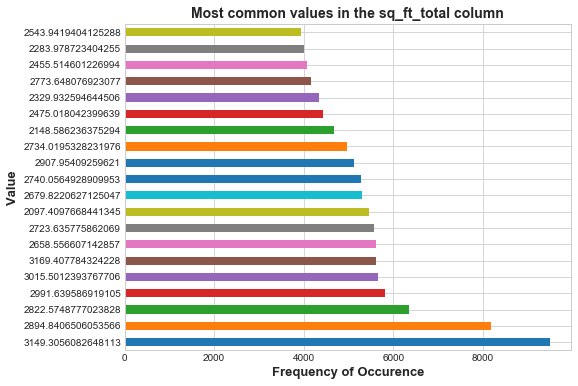


**************************************************

BEDROOMS

Data type: float64
Count: 301003
Number of Unique Values: 214
Number of nulls: 0 - 0.0%

Mean: 3.5303136513589575
Minimum: 1.0
Lower Quartile: 3.3085714285714287
Median: 3.626993865030675
Upper Quartile: 3.794224396402083
Maximum: 4.0


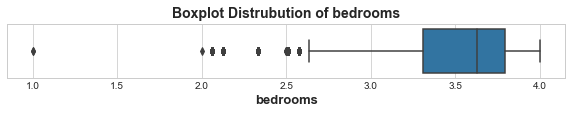

None



1.0                      2
2.0                      1
2.06                    50
                      ... 
3.9830944505696437    2721
3.9882985452245414    9486
4.0                      2
Name: bedrooms, Length: 214, dtype: int64

None



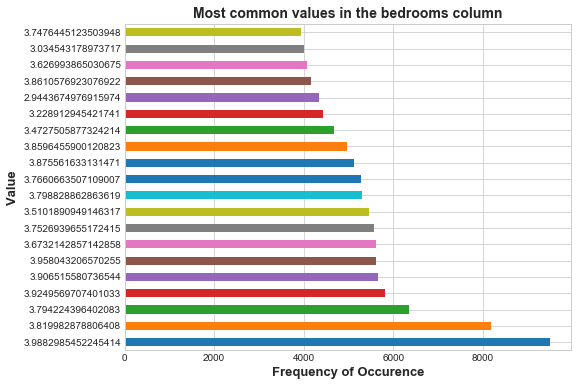


**************************************************

BATHS_FULL

Data type: float64
Count: 301003
Number of Unique Values: 213
Number of nulls: 0 - 0.0%

Mean: 2.3423122028684094
Minimum: 1.0
Lower Quartile: 2.11900826446281
Median: 2.404852160727824
Upper Quartile: 2.5373737373737373
Maximum: 3.0580668871738332


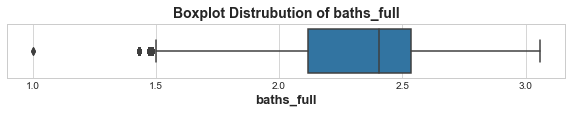

None



1.0                      2
1.4326923076923077     104
1.4723127035830619     307
                      ... 
2.736196319018405      652
2.8092979127134723    9486
3.0580668871738332    2721
Name: baths_full, Length: 213, dtype: int64

None



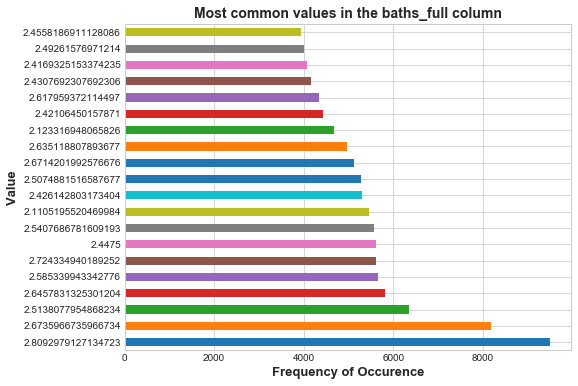


**************************************************

BATHS_HALF

Data type: float64
Count: 301003
Number of Unique Values: 211
Number of nulls: 0 - 0.0%

Mean: 0.5544396567476073
Minimum: 0.0
Lower Quartile: 0.46569779867493055
Median: 0.5570539419087137
Upper Quartile: 0.6623456035220741
Maximum: 0.8765004616805171


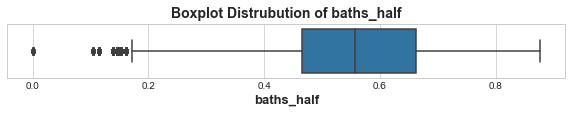

None



0.0                      17
0.10526315789473684      19
0.11538461538461539     104
                       ... 
0.851123595505618       356
0.8543956043956044     1092
0.8765004616805171     4332
Name: baths_half, Length: 211, dtype: int64

None



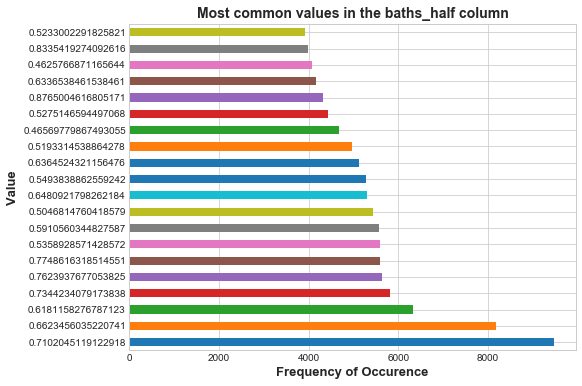


**************************************************

STORIES

Data type: float64
Count: 301003
Number of Unique Values: 212
Number of nulls: 0 - 0.0%

Mean: 1.5716022763892716
Minimum: 1.0
Lower Quartile: 1.4532955041466609
Median: 1.5395421436004162
Upper Quartile: 1.656651908075058
Maximum: 2.6904761904761907


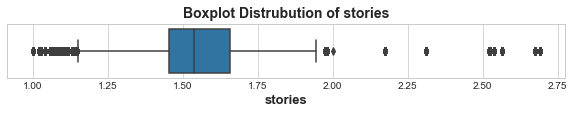

None



1.0                     25
1.0216216216216216     185
1.0288461538461537     104
                      ... 
2.5628161888701517    1186
2.6760156971375806    4332
2.6904761904761907     924
Name: stories, Length: 212, dtype: int64

None



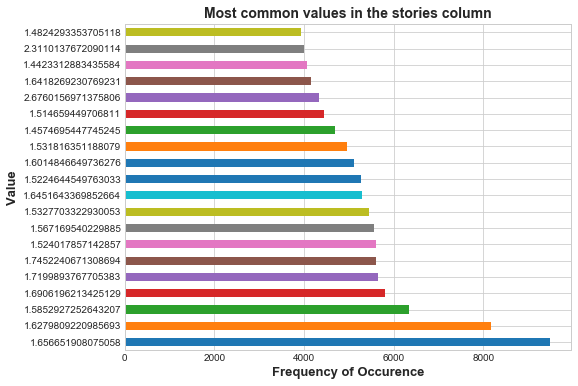


**************************************************

HOME_AGE

Data type: float64
Count: 301003
Number of Unique Values: 217
Number of nulls: 0 - 0.0%

Mean: 22.028175798912308
Minimum: 4.705882352941177
Lower Quartile: 12.318464730290456
Median: 19.460983310780335
Upper Quartile: 29.159348978046935
Maximum: 67.17307692307692


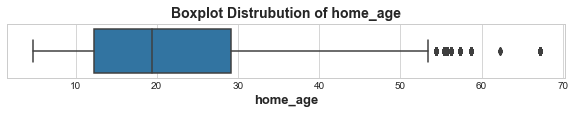

None



10.110972956170345    3217
10.137284894837476    2615
10.138649425287356    5568
                      ... 
9.291545189504372     1372
9.739827113641155     9486
9.747495580436064     3394
Name: home_age, Length: 217, dtype: int64

None



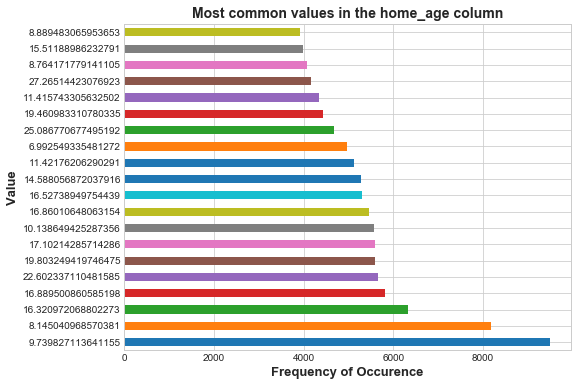


**************************************************



In [40]:
preview_cols(avg_mls)

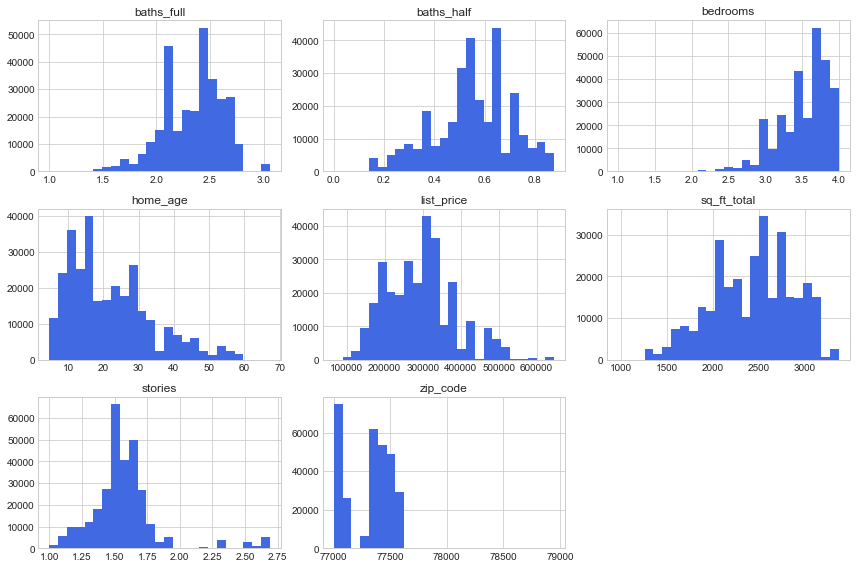

In [41]:
avg_mls[avg_mls.describe().columns].hist(bins=25, figsize=(12,8), color='royalblue')
plt.tight_layout()
plt.show()

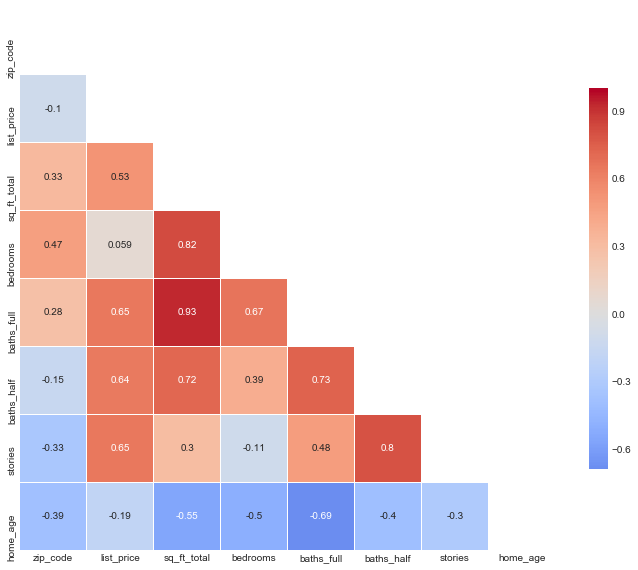

In [42]:
f, ax = plt.subplots(figsize=(12, 10))

corr = avg_mls.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(round(avg_mls.corr(),3), mask=mask, cbar_kws={'shrink':.7}, annot=True, center=0, linewidth=0.3, cmap='coolwarm');

In [43]:
avg_mls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301003 entries, 3 to 371325
Data columns (total 8 columns):
zip_code       301003 non-null int64
list_price     301003 non-null float64
sq_ft_total    301003 non-null float64
bedrooms       301003 non-null float64
baths_full     301003 non-null float64
baths_half     301003 non-null float64
stories        301003 non-null float64
home_age       301003 non-null float64
dtypes: float64(7), int64(1)
memory usage: 20.7 MB


In [44]:
len(avg_mls)-avg_mls.duplicated().sum()

217

### Saving Zip Code Averages

In [45]:
zip_avg = avg_mls.drop_duplicates(keep='first')

## Combining the Datasets

In [46]:
view(df,3)

,damagedcity,damagedzipcode,householdcomposition,homeownersinsurance,floodinsurance,flooddamage
8,MISSOURI CITY,77489,2,True,False,False
12,HOUSTON,77043,1,True,True,False
13,HOUSTON,77017,5,True,False,False
...,...,...,...,...,...,...
895516,HOUSTON,77051,1,False,False,False
895520,HOUSTON,77084,3,True,False,False
895522,EAST BERNARD,77435,1,True,True,True


In [47]:
df.rename(columns={'damagedzipcode':'zip_code', 'householdcomposition':'house_occupants'}, inplace=True)

In [48]:
# cities = df.damagedcity

In [49]:
df.drop(columns='damagedcity', inplace=True)

In [50]:
# Zipcodes in MLS dataset that are not in FEMA datasetset

list(set(mls_zips)-set(fema_zips))

[]

In [51]:
# Zipcodes in FEMA dataset that are not in MLS datasetset

list(set(fema_zips)-set(mls_zips))

[77507, 77833, 78954, 77420, 77358, 77873, 77363, 77435, 77622, 77371, 78940]

In [52]:
# Number of entries in FEMA dataset in zip codes that are not in MLS dataset

counter=0
for z in list(set(fema_zips)-set(mls_zips)):
    counter+=df[df.zip_code==z].shape[0]
print(counter)
print(str(round(counter/len(df)*100,2))+"%")

964
0.53%


In [53]:
df = df[df.zip_code!=77507]

In [54]:
view(zip_avg,3)

,zip_code,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
3,77665,183440.000000,1825.979592,3.244898,2.000000,0.346939,1.040816,41.632653
4,77554,374007.530009,1619.232687,2.934903,2.139428,0.265466,1.474608,23.779317
6,77356,326309.167118,2475.018042,3.228913,2.421065,0.527515,1.514659,19.460983
...,...,...,...,...,...,...,...,...
141853,78933,200000.000000,1626.000000,2.000000,2.000000,0.000000,2.000000,15.000000
263747,77010,439900.000000,972.000000,1.000000,1.000000,0.000000,1.000000,37.000000
323471,77046,264000.000000,1026.000000,1.000000,1.000000,0.000000,1.000000,39.000000


In [55]:
avg_df = df.merge(zip_avg, on='zip_code', how='inner')

In [56]:
view(avg_df,3)

,zip_code,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
0,77489,2,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
1,77489,2,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
2,77489,5,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
...,...,...,...,...,...,...,...,...,...,...,...,...
180068,78944,1,True,False,True,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000
180069,78944,3,True,False,False,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000
180070,78944,2,True,False,True,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000


## Checking

In [57]:
view(avg_df,3)

,zip_code,house_occupants,homeownersinsurance,floodinsurance,flooddamage,list_price,sq_ft_total,bedrooms,baths_full,baths_half,stories,home_age
0,77489,2,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
1,77489,2,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
2,77489,5,True,False,False,160808.871552,1860.828211,3.427108,2.06383,0.361702,1.427502,29.936958
...,...,...,...,...,...,...,...,...,...,...,...,...
180068,78944,1,True,False,True,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000
180069,78944,3,True,False,False,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000
180070,78944,2,True,False,True,149389.000000,2074.000000,4.000000,2.50000,0.000000,1.500000,30.000000


### Info

In [58]:
avg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180071 entries, 0 to 180070
Data columns (total 12 columns):
zip_code               180071 non-null int64
house_occupants        180071 non-null int64
homeownersinsurance    180071 non-null bool
floodinsurance         180071 non-null bool
flooddamage            180071 non-null bool
list_price             180071 non-null float64
sq_ft_total            180071 non-null float64
bedrooms               180071 non-null float64
baths_full             180071 non-null float64
baths_half             180071 non-null float64
stories                180071 non-null float64
home_age               180071 non-null float64
dtypes: bool(3), float64(7), int64(2)
memory usage: 14.3 MB


### Describe

In [59]:
avg_df.describe().T

,count,mean,std,min,25%,50%,75%,max
zip_code,180071.0,77273.130921,221.284866,77002.000000,77053.000000,77336.000000,77502.000000,78950.000000
house_occupants,180071.0,2.864037,1.702879,1.000000,1.000000,2.000000,4.000000,22.000000
list_price,180071.0,244646.235429,101161.284603,65975.000000,171265.761968,217999.581940,306716.976440,646146.891278
sq_ft_total,180071.0,2146.141255,470.298654,972.000000,1760.281553,2097.409767,2543.941940,3367.054759
bedrooms,180071.0,3.404141,0.315062,1.000000,3.143478,3.411069,3.673214,4.000000
baths_full,180071.0,2.125974,0.317861,1.000000,1.933665,2.113752,2.402930,3.058067
baths_half,180071.0,0.458969,0.172199,0.000000,0.329787,0.465698,0.577966,0.876500
stories,180071.0,1.438814,0.250414,1.000000,1.256522,1.457470,1.593682,2.690476
home_age,180071.0,29.712464,13.591341,4.705882,19.028050,27.872059,41.397849,67.173077


### Boxplot Distributions

In [60]:
num_cols = avg_df.describe().columns[1:]

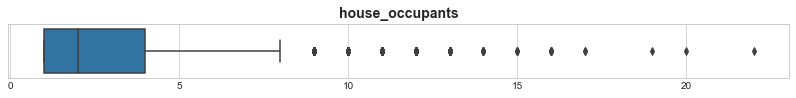

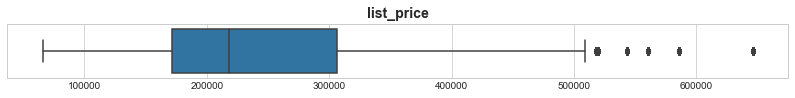

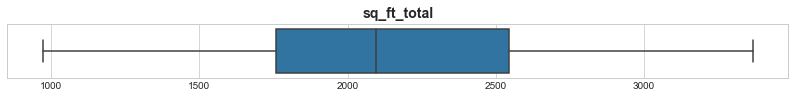

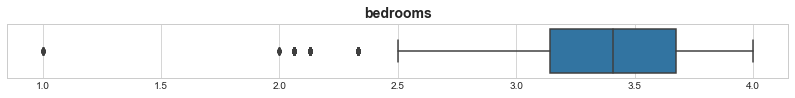

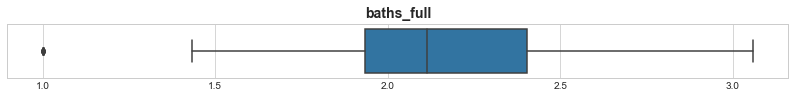

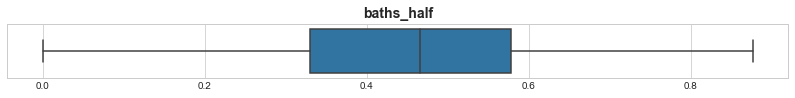

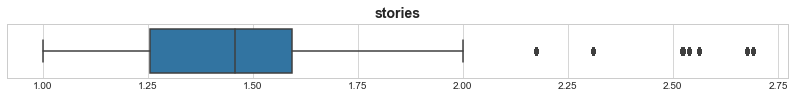

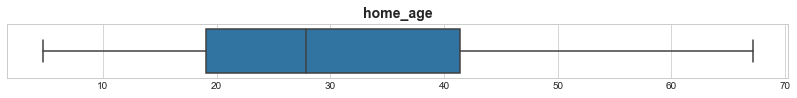

In [61]:
for n in num_cols:
    plt.figure(figsize=(14,1))
    sns.boxplot(avg_df[n])
    plt.title(n, fontsize=14, fontweight='bold')
    plt.xlabel("", fontsize=13, fontweight='bold')
    plt.show()

### Histograms

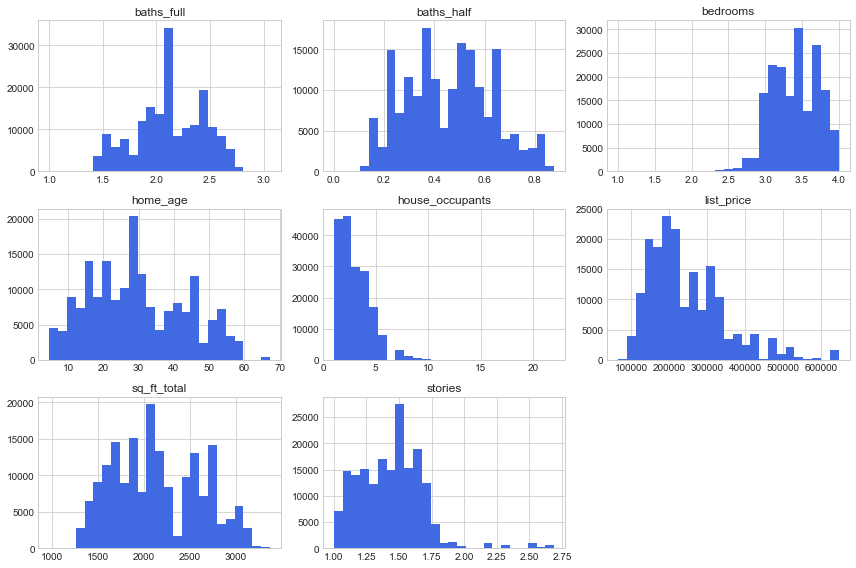

In [62]:
avg_df[num_cols].hist(bins=25, figsize=(12,8), color='royalblue')
plt.tight_layout()
plt.show()

### Multicollinearity Heat Map

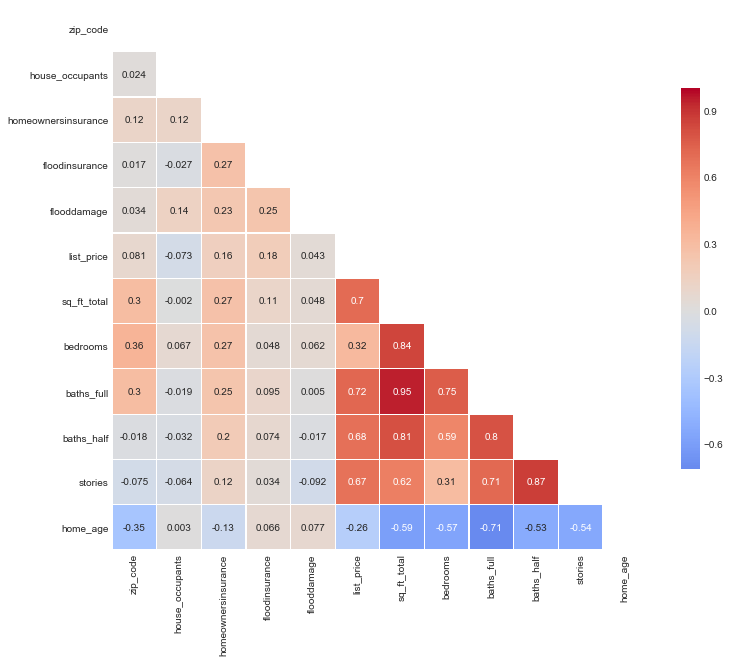

In [63]:
import seaborn as sns
f, ax = plt.subplots(figsize=(12, 10))

corr = avg_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(round(avg_df.corr(),3), mask=mask, cbar_kws={'shrink':.7}, annot=True, center=0, linewidth=0.3, cmap='coolwarm');

## Exporting DataFrame

In [64]:
avg_df.to_csv('fema_mls_merged.csv')